# Summary

# Business Understanding

# Data Understanding

### Importing relevant libraries

In [1]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from xgboost import XGBClassifier


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the dataset


In [3]:
df = pd.read_csv(r'C:\Users\user\Documents\MORINGA\Phase4\Project\Twitter-Sentiment-Analysis\judge-1377884607_tweet_product_company.csv', encoding= 'ISO-8859-1')
  

In [4]:
# Printing the first five rows of the data set
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Data Cleaning

In [5]:
# Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


* There are 9093 rows and three columns in our dataset.
* There are missing values in two columns.

In [6]:
# checking for any pattern in the missing values
# emotion_in_tweet_is directed_at column
df['emotion_in_tweet_is_directed_at'].value_counts()


emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [7]:
# is_there_an_emotion_directed_at_a_brand_or_product column
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [8]:
df['tweet_text'].value_counts()

tweet_text
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                 5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                              4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                 4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                              3
RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter                                       2
                                                                                                                                              ..
Great interview to @mention on Bloomberg TV about #Ipad2 to kick off #SxSW.#apple {link}                               

#### Handling missing values

In [9]:
# Dropping the null value on 'tweet_text' column
df = df.dropna(subset=['tweet_text'])

In [10]:
# Dropping the null values on'emotion_in_tweet_is_directed_at' column
df= df .dropna(subset=['emotion_in_tweet_is_directed_at'])

In [11]:
# Checking for null values after dropping null values
df.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [12]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()


is_there_an_emotion_directed_at_a_brand_or_product
Positive emotion                      2672
Negative emotion                       519
No emotion toward brand or product      91
I can't tell                             9
Name: count, dtype: int64

In [13]:
# merging the 'i cant tell' and 'No emotion' and renaming it neutral
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({'No emotion toward brand or product': 'Neutral', "I can't tell": 'Neutral'})

In [14]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Positive emotion    2672
Negative emotion     519
Neutral              100
Name: count, dtype: int64

#### Cleaning Text Data

In [15]:

# Function to clean text
def clean_text(text):
    # Ensure text is a string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove hashtags (including the # symbol)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and punctuation (except spaces)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    return text
   
     #Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

# Function to apply lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

# Apply text cleaning to the "tweet_text" column
df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_text)

# Tokenize the "tweet_text" column
df['tokenized_tweet'] = df['cleaned_tweet_text'].apply(lambda x: word_tokenize(x))

# Apply lemmatization to the tokenized text
df['lemmatized_tweet'] = df['tokenized_tweet'].apply(lemmatize_text)

# Display the DataFrame with cleaned, tokenized, and lemmatized text
print(df[['tweet_text', 'cleaned_tweet_text', 'tokenized_tweet', 'lemmatized_tweet']])

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9077  @mention your PR guy just convinced me to swit...   
9079  &quot;papyrus...sort of like the ipad&quot; - ...   
9080  Diller says Google TV &quot;might be run over ...   
9085  I've always used Camera+ for my iPhone b/c it ...   
9088                      Ipad everywhere. #SXSW {link}   

                                     cleaned_tweet_text  \
0     wesley83 i have a 3g iphone after 3 hrs tweeti...   
1     jessedee know about fludapp  awesome ipadiphon...   
2     swonderlin can not wait for  2 also they shoul...   
3     sxsw i hope this years festival isnt as crashy...

### Exploratory Data Analysis

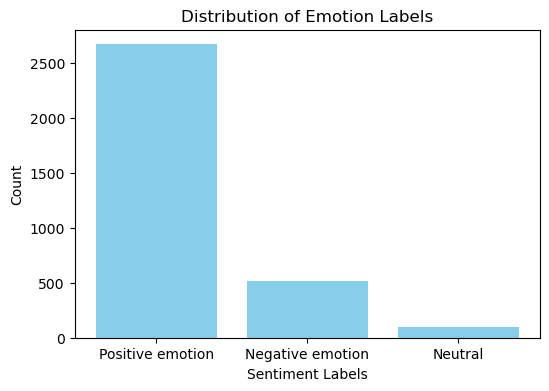

In [16]:
# Assuming you have a DataFrame 'df' with a 'sentiment' column
sentiment_counts = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Create a bar chart to visualize sentiment distribution
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color="skyblue")
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of Emotion Labels')
plt.show()

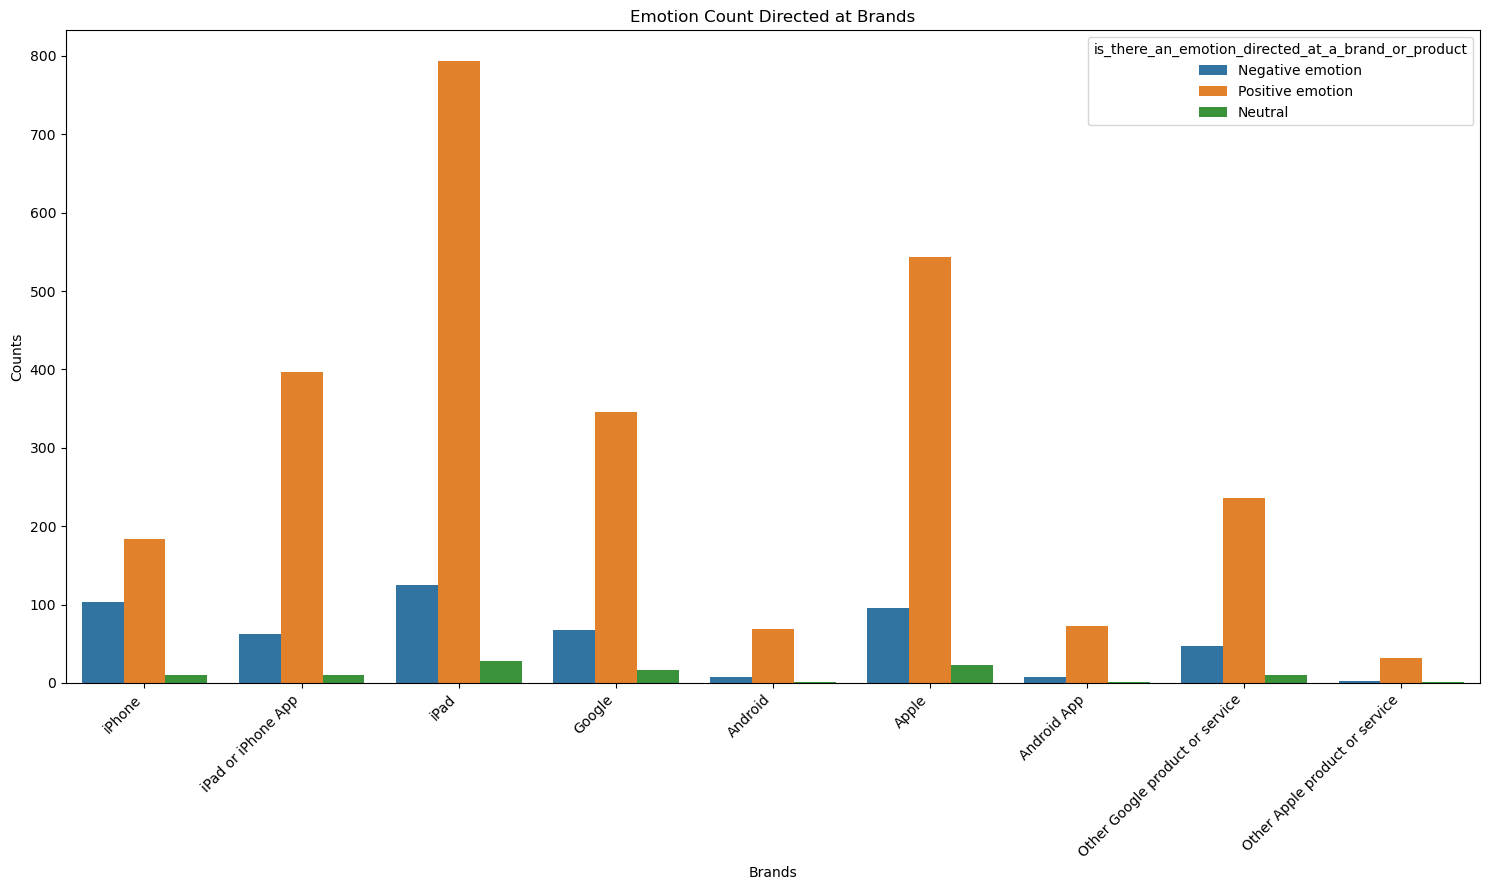

In [17]:
#plot the distribution of the count for is_there_an_emotion_directed_at_a_brand_or_product
plt.figure(figsize=(15,9))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue = 'is_there_an_emotion_directed_at_a_brand_or_product',data = df)
plt.title('Emotion Count Directed at Brands')
plt.xlabel('Brands')
plt.ylabel('Counts')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

### Modeling
1. Baseline Model - Logistic Regression

##### Label Encoding for the target feature

In [18]:
# Create a LabelEncoder object to make sure 0 represents negative,1 represents Neutral and 2 represents Positive.
label_encoder = LabelEncoder()

# Fit and transform the 'is_there_an_emotion_directed_at_a_brand_or_product' column
df['type_of_emotion_encoded'] = label_encoder.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])
print(list(label_encoder.classes_))


['Negative emotion', 'Neutral', 'Positive emotion']


##### Train - Test Split

In [19]:
# Vectorization
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Joining the lemmatized tweets into a single string with space as a separator
df['lemmatized_tweet'] = df['lemmatized_tweet'].apply(lambda x: ' '.join(x))

# Fitting and transforming the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_tweet'])


In [20]:
# Preparing features and target variable
X = tfidf_matrix 
y = df['type_of_emotion_encoded']

# Split the data into training and testing sets using 80% training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Logistic Regression model
model = LogisticRegression(max_iter=1000) 
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.18      0.30       105
           1       0.00      0.00      0.00        19
           2       0.84      0.99      0.91       535

    accuracy                           0.84       659
   macro avg       0.57      0.39      0.40       659
weighted avg       0.82      0.84      0.78       659



c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Evaluation
* The model performs well for class 2(predicting positive emotions) but poorly for class 1(predicting neutral emotions). This indicates a potential issue, such as class imbalance, where the model has learned to predict the majority class (class 2) effectively but fails to identify instances of class 1.
* The low recall and precision for class 1 suggest that improvements are needed to handle this class better.

2. XGBOOST Model

In [21]:

# Preparing features and target variable
X = tfidf_matrix 
y = df['type_of_emotion_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training the XGBOOST model
# Initialize the XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=len(y.unique()),   # Number of unique classes
    eval_metric='mlogloss',       # Evaluation metric
    scale_pos_weight=None,        # Set for handling class imbalance if needed
    use_label_encoder=False,       # To avoid warnings
    random_state=42
)

# Fitting the model
xgb_model.fit(X_train, y_train)

# Making predictions
y_pred = xgb_model.predict(X_test)

# Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))




c:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:17:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[ 30   0  74]
 [  3   0  17]
 [ 19   2 514]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.29      0.38       104
           1       0.00      0.00      0.00        20
           2       0.85      0.96      0.90       535

    accuracy                           0.83       659
   macro avg       0.48      0.42      0.43       659
weighted avg       0.78      0.83      0.79       659



##### Evaluation
* The model performs well on Class 2(predicting positive emotions) but struggles significantly with Class 1(predicting neutral emotions).
* The low precision and recall for Class 1 indicate that the model is not effectively capturing that class.


3. XGBOOST with hyperparameter tuning

In [23]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2]
}


In [24]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='f1_weighted',  # Use F1 score for better class imbalance handling
                           n_jobs=-1, cv=3, verbose=1)


In [25]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'